# Data Preprocessing and Feature Engineering

## Overview

This notebook performs comprehensive data preprocessing and feature engineering following machine learning best practices. The key principle is to prevent data leakage by splitting the data early and using only training data to fit any transformers.

## Critical Workflow Order

1. **Data Cleaning** (Before Split) - Handle missing values, outliers, duplicates
2. **Train-Test Split** (Early) - Split data to prevent leakage
3. **Feature Engineering** (After Split) - Use only training data to fit transformers
4. **Apply Transformers** - Use fitted transformers on both training and test data
5. **Validation** - Ensure quality and no data leakage
6. **Save Results** - Store processed data for modeling

## Why This Order Matters

- **Data Leakage Prevention**: Test set remains completely unseen during feature engineering
- **Realistic Evaluation**: Model performance reflects real-world scenarios
- **Reproducibility**: All transformations are documented and saved
- **Best Practices**: Follows standard machine learning workflow

All preprocessing steps are configurable through `config.toml` for reproducibility and consistency.

In [1]:
# Import required libraries for preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from pathlib import Path
import warnings
from datetime import datetime

# Machine learning libraries
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy import stats
from scipy.stats import boxcox

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration
import toml

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')

print("Libraries imported successfully!")
print("=" * 50)

# Load configuration
config = toml.load('../config.toml')

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])

# Display preprocessing configuration
print("Preprocessing Configuration:")
print(f"Imputation strategy: {config['preprocessing']['imputation_strategy']}")
print(f"Outlier method: {config['preprocessing']['outlier_method']}")
print(f"Normalization method: {config['preprocessing']['normalization_method']}")
print(f"Test size: {config['split']['test_size']}")
print(f"Random state: {config['split']['random_state']}")
print(f"Stratify split: {config['split']['stratify']}")

Libraries imported successfully!
Preprocessing Configuration:
Imputation strategy: mean
Outlier method: iqr
Normalization method: zscore
Test size: 0.2
Random state: 11
Stratify split: True


## Loading Data and Previous Analysis Results

Before we begin preprocessing, we need to load:

1. **Original Data**: The raw dataset from the first notebook
2. **EDA Results**: Quality assessment and findings from the second notebook
3. **Metadata**: Information about columns and data structure

This ensures our preprocessing decisions are informed by the comprehensive analysis we performed earlier.

In [2]:
import pickle
from pathlib import Path

print("Loading data from previous notebooks...")
print("=" * 50)

# Define data directory
data_dir = Path('../data/processed')

# Load data objects from data ingestion
with open(data_dir / '01_data_ingestion.pkl', 'rb') as f:
    ingestion_data = pickle.load(f)

# Load EDA results
with open(data_dir / '02_eda_results.pkl', 'rb') as f:
    eda_results = pickle.load(f)

# Extract data components
df = ingestion_data['data']['df'].copy()  # Make a copy to avoid modifying original
feature_cols = ingestion_data['data']['feature_cols']
sample_id_col = ingestion_data['metadata']['sample_id_col']
label_col = ingestion_data['metadata']['label_col']

# Extract metadata
n_features = ingestion_data['metadata']['n_features']
n_samples = ingestion_data['metadata']['n_samples']
label_distribution = ingestion_data['metadata']['label_distribution']

# Extract EDA results
quality_metrics = eda_results['quality_metrics']
recommendations = eda_results['recommendations']
quality_score = eda_results['quality_score']
correlation_matrix = eda_results['correlation_matrix']
high_corr_pairs = eda_results['high_corr_pairs']
outliers_by_feature = eda_results['outliers_by_feature']
class_distribution = eda_results['class_distribution']
feature_variances = eda_results['feature_variances']
analysis_timestamp = eda_results['analysis_timestamp']

# Summary printout
print("Data loaded successfully!")
print(f"Original dataset shape: {df.shape}")
print(f"Number of features: {n_features}")
print(f"Number of samples: {n_samples}")
print(f"Target variable: {label_col}")
print(f"Label distribution: {label_distribution}")

# EDA Summary
print(f"\nEDA Quality Score: {quality_score}/100")
print(f"Missing values: {quality_metrics['missing_values_percent']:.2f}%")
print(f"Outliers: {quality_metrics['outlier_percent']:.2f}%")
print(f"Class balance ratio: {quality_metrics['class_balance_ratio']:.3f}")

# Show EDA recommendations
print(f"\nEDA Recommendations ({len(recommendations)}):")
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

# Timestamp info
print(f"\nAnalysis performed at: {analysis_timestamp}")

Loading data from previous notebooks...
Data loaded successfully!
Original dataset shape: (172, 4362)
Number of features: 4360
Number of samples: 172
Target variable: label
Label distribution: {'Tumor': 122, 'Healthy': 50}

EDA Quality Score: 90/100
Missing values: 0.00%
Outliers: 5.71%
Class balance ratio: 0.410

EDA Recommendations (2):
  1. Consider feature selection to remove highly correlated features
  2. Investigate features with low uniqueness

Analysis performed at: 2025-07-11T08:33:54.143328


## Preprocessing Plan

Based on our EDA findings and best practices, we'll implement the following preprocessing steps:

## Phase 1: Data Cleaning

### Step 1: Missing Value Treatment

**Why handle missing values before splitting?**

- Missing values can affect the split process
- Basic cleaning should be done on the entire dataset
- No risk of data leakage for simple imputation

**Imputation Strategies:**

- **Mean**: Replace with feature mean (good for normally distributed data)
- **Median**: Replace with feature median (robust to outliers)
- **Most Frequent**: Replace with most common value (good for categorical data)
- **KNN**: Use k-nearest neighbors to estimate missing values
- **None**: Remove rows with missing values (if missing data is minimal)

**Our Approach:**

1. Analyze missing value patterns
2. Choose appropriate imputation strategy from config
3. Apply imputation to features and handle target separately
4. Validate imputation results

In [3]:
# Phase 1: Data Cleaning
print("Phase 1: Data Cleaning")
print("=" * 50)

# Step 1: Missing Value Treatment
print("Step 1: Missing Value Treatment")
print("-" * 30)

# Analyze missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

print("Missing Value Analysis:")
print(f"Total missing values: {missing_data.sum()}")
print(f"Overall missing percentage: {missing_data.sum() / (len(df) * len(df.columns)) * 100:.2f}%")

# Show features with missing values
features_with_missing = missing_data[missing_data > 0]
if len(features_with_missing) > 0:
    print(f"\nFeatures with missing values ({len(features_with_missing)}):")
    for feature, count in features_with_missing.items():
        print(f"  {feature}: {count} ({missing_percent[feature]:.2f}%)")
else:
    print("\n✓ No missing values found in features.")

# Check target variable for missing values
if df[label_col].isnull().sum() > 0:
    print(f"\n⚠️  Missing values in target variable: {df[label_col].isnull().sum()}")
    # Remove rows with missing target (we can't impute the target)
    df = df.dropna(subset=[label_col])
    print(f"Removed {len(df)} rows with missing target values")
else:
    print(f"\n✓ No missing values in target variable")

# Apply imputation strategy
imputation_strategy = config['preprocessing']['imputation_strategy']
print(f"\nApplying imputation strategy: {imputation_strategy}")

if imputation_strategy != "none" and len(features_with_missing) > 0:
    # Prepare feature data for imputation
    X_features = df[feature_cols].copy()
    
    if imputation_strategy == "mean":
        imputer = SimpleImputer(strategy='mean')
        print("Using mean imputation (average value for each feature)")
        
    elif imputation_strategy == "median":
        imputer = SimpleImputer(strategy='median')
        print("Using median imputation (middle value for each feature)")
        
    elif imputation_strategy == "most_frequent":
        imputer = SimpleImputer(strategy='most_frequent')
        print("Using most frequent imputation (most common value for each feature)")
        
    elif imputation_strategy == "knn":
        imputer = KNNImputer(n_neighbors=5)
        print("Using KNN imputation (k=5 nearest neighbors)")
    
    # Fit and transform
    X_imputed = imputer.fit_transform(X_features)
    df[feature_cols] = X_imputed
    
    print("✓ Imputation completed successfully")
    
    # Save imputer for later use
    imputer_info = {
        'imputer': imputer,
        'strategy': imputation_strategy,
        'features_imputed': list(features_with_missing.index)
    }
    
else:
    print("✓ No imputation needed (no missing values or strategy is 'none')")
    imputer_info = None

# Validate imputation
missing_after = df.isnull().sum().sum()
print(f"\nValidation:")
print(f"Missing values after imputation: {missing_after}")
if missing_after == 0:
    print("✓ All missing values have been successfully handled")
else:
    print(f"⚠️  {missing_after} missing values remain")

print(f"Dataset shape after missing value treatment: {df.shape}")

Phase 1: Data Cleaning
Step 1: Missing Value Treatment
------------------------------
Missing Value Analysis:
Total missing values: 0
Overall missing percentage: 0.00%

✓ No missing values found in features.

✓ No missing values in target variable

Applying imputation strategy: mean
✓ No imputation needed (no missing values or strategy is 'none')

Validation:
Missing values after imputation: 0
✓ All missing values have been successfully handled
Dataset shape after missing value treatment: (172, 4362)


### Step 2: Outlier Detection and Treatment

**Why handle outliers before splitting?**

- Outliers can affect the split process and class distribution
- Basic outlier treatment doesn't involve complex statistics
- No risk of data leakage for simple outlier methods

**Outlier Detection Methods:**

- **IQR Method**: Uses interquartile range (Q3 - Q1) to identify outliers
- **Z-Score Method**: Uses standard deviations from the mean
- **Isolation Forest**: Machine learning approach to detect outliers
- **None**: Skip outlier detection

**Treatment Strategies:**

- **Remove**: Delete outlier samples (if percentage is low)
- **Cap**: Limit outliers to reasonable bounds
- **Investigate**: Flag for manual review (if percentage is high)

In [4]:
# Step 2: Outlier Detection and Treatment
print("\nStep 2: Outlier Detection and Treatment")
print("-" * 40)

outlier_method = config['preprocessing']['outlier_method']
print(f"Using outlier detection method: {outlier_method}")

# Prepare data for outlier detection
X_features = df[feature_cols].copy()

outlier_info = {
    'method': outlier_method,
    'outliers_by_feature': {},
    'total_outliers': 0,
    'outlier_indices': set()
}

if outlier_method == "iqr":
    print("Using IQR method for outlier detection")
    print("Outliers: values < Q1 - 1.5*IQR or > Q3 + 1.5*IQR")
    
    for col in feature_cols:
        Q1 = X_features[col].quantile(0.25)
        Q3 = X_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((X_features[col] < lower_bound) | (X_features[col] > upper_bound))
        outlier_count = outliers.sum()
        outlier_info['outliers_by_feature'][col] = outlier_count
        outlier_info['total_outliers'] += outlier_count
        
        if outlier_count > 0:
            outlier_indices = outliers[outliers].index
            outlier_info['outlier_indices'].update(outlier_indices)
            
            print(f"  {col}: {outlier_count} outliers ({outlier_count/len(df)*100:.1f}%)")

elif outlier_method == "zscore":
    print("Using Z-score method for outlier detection")
    print("Outliers: values with |z-score| > 3")
    
    z_scores = np.abs(stats.zscore(X_features))
    threshold = 3.0
    
    for i, col in enumerate(feature_cols):
        outliers = z_scores[:, i] > threshold
        outlier_count = outliers.sum()
        outlier_info['outliers_by_feature'][col] = outlier_count
        outlier_info['total_outliers'] += outlier_count
        
        if outlier_count > 0:
            outlier_indices = np.where(outliers)[0]
            outlier_info['outlier_indices'].update(outlier_indices)
            
            print(f"  {col}: {outlier_count} outliers ({outlier_count/len(df)*100:.1f}%)")

elif outlier_method == "isolation_forest":
    print("Using Isolation Forest for outlier detection")
    
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outlier_labels = iso_forest.fit_predict(X_features)
    outliers = outlier_labels == -1
    outlier_count = outliers.sum()
    
    outlier_info['total_outliers'] = outlier_count
    outlier_info['outlier_indices'] = set(np.where(outliers)[0])
    
    print(f"  Total outliers detected: {outlier_count} ({outlier_count/len(df)*100:.1f}%)")

else:
    print("Skipping outlier detection (method: none)")

# Analyze outlier impact and decide treatment
if outlier_info['total_outliers'] > 0:
    outlier_percentage = len(outlier_info['outlier_indices']) / len(df) * 100
    print(f"\nOutlier Analysis:")
    print(f"Total unique samples with outliers: {len(outlier_info['outlier_indices'])}")
    print(f"Percentage of samples with outliers: {outlier_percentage:.1f}%")
    
    # Decide on treatment strategy
    if outlier_percentage > 20:
        print("⚠️  High outlier percentage - will cap outliers")
        treatment_strategy = "cap"
    elif outlier_percentage > 5:
        print("Moderate outlier percentage - will cap outliers")
        treatment_strategy = "cap"
    else:
        print("Low outlier percentage - will remove outliers")
        treatment_strategy = "remove"
    
    # Apply treatment
    if treatment_strategy == "remove":
        print("\nRemoving outlier samples...")
        df_clean = df.drop(index=list(outlier_info['outlier_indices']))
        removed_count = len(df) - len(df_clean)
        df = df_clean
        print(f"Removed {removed_count} samples with outliers")
        
    elif treatment_strategy == "cap":
        print("\nCapping outliers to 95th and 5th percentiles...")
        for col in feature_cols:
            if outlier_info['outliers_by_feature'].get(col, 0) > 0:
                lower_bound = X_features[col].quantile(0.05)
                upper_bound = X_features[col].quantile(0.95)
                df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print("✓ Outliers capped successfully")
    
    outlier_info['treatment_strategy'] = treatment_strategy
    outlier_info['outlier_percentage'] = outlier_percentage
    
else:
    print("✓ No outliers detected")
    outlier_info['treatment_strategy'] = "none"
    outlier_info['outlier_percentage'] = 0

print(f"Dataset shape after outlier treatment: {df.shape}")


Step 2: Outlier Detection and Treatment
----------------------------------------
Using outlier detection method: iqr
Using IQR method for outlier detection
Outliers: values < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
  hsa-let-7a-1: 1 outliers (0.6%)
  hsa-let-7a-2: 1 outliers (0.6%)
  hsa-let-7a-3: 1 outliers (0.6%)
  hsa-let-7b: 2 outliers (1.2%)
  hsa-let-7c: 1 outliers (0.6%)
  hsa-let-7d: 2 outliers (1.2%)
  hsa-let-7e: 4 outliers (2.3%)
  hsa-let-7f-1: 1 outliers (0.6%)
  hsa-let-7f-2: 2 outliers (1.2%)
  hsa-let-7i: 1 outliers (0.6%)
  hsa-mir-1-1: 28 outliers (16.3%)
  hsa-mir-1-2: 1 outliers (0.6%)
  hsa-mir-10226: 40 outliers (23.3%)
  hsa-mir-10392: 5 outliers (2.9%)
  hsa-mir-10393: 20 outliers (11.6%)
  hsa-mir-10394: 5 outliers (2.9%)
  hsa-mir-10395: 31 outliers (18.0%)
  hsa-mir-10396a: 1 outliers (0.6%)
  hsa-mir-10396b: 2 outliers (1.2%)
  hsa-mir-10397: 25 outliers (14.5%)
  hsa-mir-10399: 16 outliers (9.3%)
  hsa-mir-103a-1: 1 outliers (0.6%)
  hsa-mir-103a-2: 1 outliers (0.6

  hsa-mir-12122: 34 outliers (19.8%)
  hsa-mir-12123: 26 outliers (15.1%)
  hsa-mir-12124: 1 outliers (0.6%)
  hsa-mir-12125: 3 outliers (1.7%)
  hsa-mir-12126: 7 outliers (4.1%)
  hsa-mir-12127: 5 outliers (2.9%)
  hsa-mir-12128: 8 outliers (4.7%)
  hsa-mir-12129: 10 outliers (5.8%)
  hsa-mir-12130: 37 outliers (21.5%)
  hsa-mir-12131: 26 outliers (15.1%)
  hsa-mir-12132: 38 outliers (22.1%)
  hsa-mir-12133: 7 outliers (4.1%)
  hsa-mir-12135: 6 outliers (3.5%)
  hsa-mir-12136: 10 outliers (5.8%)
  hsa-mir-122: 11 outliers (6.4%)
  hsa-mir-1224: 1 outliers (0.6%)
  hsa-mir-1225: 1 outliers (0.6%)
  hsa-mir-1226: 2 outliers (1.2%)
  hsa-mir-1228: 5 outliers (2.9%)
  hsa-mir-1229: 1 outliers (0.6%)
  hsa-mir-122b: 10 outliers (5.8%)
  hsa-mir-1231: 1 outliers (0.6%)
  hsa-mir-1234: 1 outliers (0.6%)
  hsa-mir-1236: 9 outliers (5.2%)
  hsa-mir-1237: 11 outliers (6.4%)
  hsa-mir-124-1: 37 outliers (21.5%)
  hsa-mir-124-2: 3 outliers (1.7%)
  hsa-mir-1243: 41 outliers (23.8%)
  hsa-mir-1244

  hsa-mir-3150b: 7 outliers (4.1%)
  hsa-mir-3151: 7 outliers (4.1%)
  hsa-mir-3152: 40 outliers (23.3%)
  hsa-mir-3153: 5 outliers (2.9%)
  hsa-mir-3154: 4 outliers (2.3%)
  hsa-mir-3155a: 10 outliers (5.8%)
  hsa-mir-3155b: 6 outliers (3.5%)
  hsa-mir-3156-1: 5 outliers (2.9%)
  hsa-mir-3156-2: 5 outliers (2.9%)
  hsa-mir-3156-3: 9 outliers (5.2%)
  hsa-mir-3157: 1 outliers (0.6%)
  hsa-mir-3158-1: 1 outliers (0.6%)
  hsa-mir-3158-2: 1 outliers (0.6%)
  hsa-mir-3160-1: 4 outliers (2.3%)
  hsa-mir-3160-2: 4 outliers (2.3%)
  hsa-mir-3161: 41 outliers (23.8%)
  hsa-mir-3162: 4 outliers (2.3%)
  hsa-mir-3163: 1 outliers (0.6%)
  hsa-mir-3164: 2 outliers (1.2%)
  hsa-mir-3165: 26 outliers (15.1%)
  hsa-mir-3166: 14 outliers (8.1%)
  hsa-mir-3167: 34 outliers (19.8%)
  hsa-mir-3168: 3 outliers (1.7%)
  hsa-mir-3169: 10 outliers (5.8%)
  hsa-mir-3170: 8 outliers (4.7%)
  hsa-mir-3171: 8 outliers (4.7%)
  hsa-mir-3173: 3 outliers (1.7%)
  hsa-mir-3174: 3 outliers (1.7%)
  hsa-mir-3175: 2 ou

  hsa-mir-3182: 2 outliers (1.2%)
  hsa-mir-3183: 5 outliers (2.9%)
  hsa-mir-3184: 1 outliers (0.6%)
  hsa-mir-3185: 9 outliers (5.2%)
  hsa-mir-3186: 39 outliers (22.7%)
  hsa-mir-3187: 15 outliers (8.7%)
  hsa-mir-3189: 18 outliers (10.5%)
  hsa-mir-3190: 4 outliers (2.3%)
  hsa-mir-3191: 4 outliers (2.3%)
  hsa-mir-3192: 1 outliers (0.6%)
  hsa-mir-3193: 24 outliers (14.0%)
  hsa-mir-3194: 3 outliers (1.7%)
  hsa-mir-3195: 1 outliers (0.6%)
  hsa-mir-3197: 2 outliers (1.2%)
  hsa-mir-3198-1: 4 outliers (2.3%)
  hsa-mir-3198-2: 3 outliers (1.7%)
  hsa-mir-3199-1: 30 outliers (17.4%)
  hsa-mir-3199-2: 29 outliers (16.9%)
  hsa-mir-32: 1 outliers (0.6%)
  hsa-mir-3200: 9 outliers (5.2%)
  hsa-mir-3201: 5 outliers (2.9%)
  hsa-mir-3202-1: 7 outliers (4.1%)
  hsa-mir-3202-2: 7 outliers (4.1%)
  hsa-mir-320a: 2 outliers (1.2%)
  hsa-mir-320d-1: 1 outliers (0.6%)
  hsa-mir-320d-2: 1 outliers (0.6%)
  hsa-mir-320e: 13 outliers (7.6%)
  hsa-mir-323a: 1 outliers (0.6%)
  hsa-mir-323b: 3 outl

  hsa-mir-3649: 23 outliers (13.4%)
  hsa-mir-3650: 12 outliers (7.0%)
  hsa-mir-3651: 6 outliers (3.5%)
  hsa-mir-3652: 3 outliers (1.7%)
  hsa-mir-3654: 27 outliers (15.7%)
  hsa-mir-3655: 2 outliers (1.2%)
  hsa-mir-3657: 17 outliers (9.9%)
  hsa-mir-3658: 2 outliers (1.2%)
  hsa-mir-365a: 1 outliers (0.6%)
  hsa-mir-365b: 1 outliers (0.6%)
  hsa-mir-3660: 43 outliers (25.0%)
  hsa-mir-3661: 8 outliers (4.7%)
  hsa-mir-3662: 5 outliers (2.9%)
  hsa-mir-3663: 12 outliers (7.0%)
  hsa-mir-3664: 5 outliers (2.9%)
  hsa-mir-3666: 43 outliers (25.0%)
  hsa-mir-3667: 6 outliers (3.5%)
  hsa-mir-3668: 15 outliers (8.7%)
  hsa-mir-367: 25 outliers (14.5%)
  hsa-mir-3670-1: 40 outliers (23.3%)
  hsa-mir-3670-2: 40 outliers (23.3%)
  hsa-mir-3670-3: 40 outliers (23.3%)
  hsa-mir-3670-4: 40 outliers (23.3%)
  hsa-mir-3671: 24 outliers (14.0%)
  hsa-mir-3672: 22 outliers (12.8%)
  hsa-mir-3674: 26 outliers (15.1%)
  hsa-mir-3675: 21 outliers (12.2%)
  hsa-mir-3677: 26 outliers (15.1%)
  hsa-mir

  hsa-mir-4649: 28 outliers (16.3%)
  hsa-mir-4650-1: 28 outliers (16.3%)
  hsa-mir-4650-2: 28 outliers (16.3%)
  hsa-mir-4651: 3 outliers (1.7%)
  hsa-mir-4652: 41 outliers (23.8%)
  hsa-mir-4653: 2 outliers (1.2%)
  hsa-mir-4654: 4 outliers (2.3%)
  hsa-mir-4656: 3 outliers (1.7%)
  hsa-mir-4657: 14 outliers (8.1%)
  hsa-mir-4658: 43 outliers (25.0%)
  hsa-mir-4659a: 12 outliers (7.0%)
  hsa-mir-4659b: 27 outliers (15.7%)
  hsa-mir-466: 3 outliers (1.7%)
  hsa-mir-4661: 22 outliers (12.8%)
  hsa-mir-4662a: 19 outliers (11.0%)
  hsa-mir-4662b: 20 outliers (11.6%)
  hsa-mir-4663: 9 outliers (5.2%)
  hsa-mir-4664: 3 outliers (1.7%)
  hsa-mir-4665: 2 outliers (1.2%)
  hsa-mir-4666a: 19 outliers (11.0%)
  hsa-mir-4666b: 39 outliers (22.7%)
  hsa-mir-4667: 5 outliers (2.9%)
  hsa-mir-4668: 24 outliers (14.0%)
  hsa-mir-4669: 1 outliers (0.6%)
  hsa-mir-4670: 4 outliers (2.3%)
  hsa-mir-4671: 8 outliers (4.7%)
  hsa-mir-4672: 34 outliers (19.8%)
  hsa-mir-4673: 2 outliers (1.2%)
  hsa-mir-4

  hsa-mir-4746: 40 outliers (23.3%)
  hsa-mir-4747: 6 outliers (3.5%)
  hsa-mir-4749: 24 outliers (14.0%)
  hsa-mir-4751: 1 outliers (0.6%)
  hsa-mir-4752: 2 outliers (1.2%)
  hsa-mir-4753: 41 outliers (23.8%)
  hsa-mir-4755: 2 outliers (1.2%)
  hsa-mir-4756: 35 outliers (20.3%)
  hsa-mir-4758: 1 outliers (0.6%)
  hsa-mir-4759: 19 outliers (11.0%)
  hsa-mir-4760: 20 outliers (11.6%)
  hsa-mir-4761: 4 outliers (2.3%)
  hsa-mir-4762: 39 outliers (22.7%)
  hsa-mir-4763: 1 outliers (0.6%)
  hsa-mir-4764: 33 outliers (19.2%)
  hsa-mir-4768: 28 outliers (16.3%)
  hsa-mir-4769: 3 outliers (1.7%)
  hsa-mir-4770: 4 outliers (2.3%)
  hsa-mir-4771-1: 29 outliers (16.9%)
  hsa-mir-4771-2: 29 outliers (16.9%)
  hsa-mir-4772: 17 outliers (9.9%)
  hsa-mir-4773-1: 5 outliers (2.9%)
  hsa-mir-4773-2: 5 outliers (2.9%)
  hsa-mir-4774: 31 outliers (18.0%)
  hsa-mir-4775: 25 outliers (14.5%)
  hsa-mir-4776-1: 1 outliers (0.6%)
  hsa-mir-4776-2: 1 outliers (0.6%)
  hsa-mir-4777: 13 outliers (7.6%)
  hsa-mi

  hsa-mir-4790: 13 outliers (7.6%)
  hsa-mir-4791: 40 outliers (23.3%)
  hsa-mir-4793: 1 outliers (0.6%)
  hsa-mir-4794: 11 outliers (6.4%)
  hsa-mir-4795: 26 outliers (15.1%)
  hsa-mir-4796: 33 outliers (19.2%)
  hsa-mir-4797: 21 outliers (12.2%)
  hsa-mir-4798: 4 outliers (2.3%)
  hsa-mir-4799: 32 outliers (18.6%)
  hsa-mir-4800: 7 outliers (4.1%)
  hsa-mir-4801: 11 outliers (6.4%)
  hsa-mir-4802: 43 outliers (25.0%)
  hsa-mir-4803: 28 outliers (16.3%)
  hsa-mir-4804: 5 outliers (2.9%)
  hsa-mir-483: 1 outliers (0.6%)
  hsa-mir-484: 8 outliers (4.7%)
  hsa-mir-485: 18 outliers (10.5%)
  hsa-mir-486-1: 4 outliers (2.3%)
  hsa-mir-486-2: 4 outliers (2.3%)
  hsa-mir-487a: 24 outliers (14.0%)
  hsa-mir-487b: 43 outliers (25.0%)
  hsa-mir-488: 4 outliers (2.3%)
  hsa-mir-489: 4 outliers (2.3%)
  hsa-mir-490: 40 outliers (23.3%)
  hsa-mir-491: 6 outliers (3.5%)
  hsa-mir-492: 2 outliers (1.2%)
  hsa-mir-493: 10 outliers (5.8%)
  hsa-mir-494: 4 outliers (2.3%)
  hsa-mir-495: 41 outliers (23

  hsa-mir-6807: 3 outliers (1.7%)


  hsa-mir-6808: 14 outliers (8.1%)
  hsa-mir-6810: 39 outliers (22.7%)
  hsa-mir-6811: 16 outliers (9.3%)
  hsa-mir-6812: 5 outliers (2.9%)
  hsa-mir-6813: 7 outliers (4.1%)


  hsa-mir-6814: 37 outliers (21.5%)
  hsa-mir-6815: 3 outliers (1.7%)
  hsa-mir-6816: 6 outliers (3.5%)
  hsa-mir-6817: 8 outliers (4.7%)
  hsa-mir-6818: 41 outliers (23.8%)
  hsa-mir-6819: 11 outliers (6.4%)
  hsa-mir-6820: 32 outliers (18.6%)
  hsa-mir-6822: 35 outliers (20.3%)
  hsa-mir-6823: 5 outliers (2.9%)
  hsa-mir-6824: 5 outliers (2.9%)
  hsa-mir-6825: 3 outliers (1.7%)
  hsa-mir-6826: 15 outliers (8.7%)
  hsa-mir-6827: 36 outliers (20.9%)
  hsa-mir-6828: 2 outliers (1.2%)
  hsa-mir-6829: 9 outliers (5.2%)
  hsa-mir-6830: 29 outliers (16.9%)
  hsa-mir-6831: 35 outliers (20.3%)
  hsa-mir-6832: 6 outliers (3.5%)
  hsa-mir-6833: 4 outliers (2.3%)
  hsa-mir-6834: 1 outliers (0.6%)
  hsa-mir-6835: 6 outliers (3.5%)
  hsa-mir-6836: 26 outliers (15.1%)
  hsa-mir-6837: 4 outliers (2.3%)
  hsa-mir-6838: 33 outliers (19.2%)
  hsa-mir-6839: 3 outliers (1.7%)
  hsa-mir-6840: 10 outliers (5.8%)
  hsa-mir-6841: 28 outliers (16.3%)
  hsa-mir-6842: 26 outliers (15.1%)
  hsa-mir-6843: 3 outli

  hsa-miR-150-5p: 7 outliers (4.1%)


  hsa-miR-151a-5p: 1 outliers (0.6%)
  hsa-miR-151b: 2 outliers (1.2%)
  hsa-miR-152-3p: 33 outliers (19.2%)
  hsa-miR-152-5p: 3 outliers (1.7%)


  hsa-miR-153-5p: 3 outliers (1.7%)
  hsa-miR-1537-3p: 10 outliers (5.8%)
  hsa-miR-1538: 19 outliers (11.0%)
  hsa-miR-1539: 5 outliers (2.9%)
  hsa-miR-154-3p: 5 outliers (2.9%)
  hsa-miR-154-5p: 4 outliers (2.3%)
  hsa-miR-155-3p: 1 outliers (0.6%)
  hsa-miR-1587: 13 outliers (7.6%)
  hsa-miR-15a-3p: 8 outliers (4.7%)
  hsa-miR-15a-5p: 4 outliers (2.3%)
  hsa-miR-15b-3p: 1 outliers (0.6%)
  hsa-miR-15b-5p: 1 outliers (0.6%)
  hsa-miR-16-1-3p: 3 outliers (1.7%)
  hsa-miR-16-2-3p: 15 outliers (8.7%)
  hsa-miR-16-5p: 1 outliers (0.6%)
  hsa-miR-17-3p: 1 outliers (0.6%)
  hsa-miR-181b-2-3p: 13 outliers (7.6%)
  hsa-miR-181b-3p: 12 outliers (7.0%)
  hsa-miR-181c-3p: 2 outliers (1.2%)
  hsa-miR-181c-5p: 4 outliers (2.3%)
  hsa-miR-181d-3p: 9 outliers (5.2%)
  hsa-miR-181d-5p: 35 outliers (20.3%)
  hsa-miR-182-5p: 1 outliers (0.6%)
  hsa-miR-1825: 2 outliers (1.2%)
  hsa-miR-1827: 22 outliers (12.8%)
  hsa-miR-183-3p: 1 outliers (0.6%)
  hsa-miR-183-5p: 2 outliers (1.2%)
  hsa-miR-184: 1 o

  hsa-miR-378g: 2 outliers (1.2%)


  hsa-miR-378h: 4 outliers (2.3%)
  hsa-miR-378i: 14 outliers (8.1%)
  hsa-miR-378j: 3 outliers (1.7%)
  hsa-miR-379-3p: 1 outliers (0.6%)
  hsa-miR-379-5p: 11 outliers (6.4%)
  hsa-miR-380-5p: 1 outliers (0.6%)
  hsa-miR-381-3p: 31 outliers (18.0%)
  hsa-miR-381-5p: 9 outliers (5.2%)
  hsa-miR-382-3p: 11 outliers (6.4%)


  hsa-miR-382-5p: 4 outliers (2.3%)
  hsa-miR-383-3p: 8 outliers (4.7%)
  hsa-miR-383-5p: 9 outliers (5.2%)
  hsa-miR-384: 1 outliers (0.6%)
  hsa-miR-3907: 10 outliers (5.8%)
  hsa-miR-3909: 5 outliers (2.9%)
  hsa-miR-3910: 1 outliers (0.6%)
  hsa-miR-3911: 5 outliers (2.9%)
  hsa-miR-3912-3p: 1 outliers (0.6%)
  hsa-miR-3913-3p: 25 outliers (14.5%)
  hsa-miR-3913-5p: 25 outliers (14.5%)
  hsa-miR-3914: 19 outliers (11.0%)
  hsa-miR-3915: 8 outliers (4.7%)
  hsa-miR-3916: 1 outliers (0.6%)
  hsa-miR-3917: 3 outliers (1.7%)
  hsa-miR-3918: 1 outliers (0.6%)
  hsa-miR-3919: 12 outliers (7.0%)
  hsa-miR-3920: 1 outliers (0.6%)
  hsa-miR-3922-3p: 25 outliers (14.5%)
  hsa-miR-3922-5p: 7 outliers (4.1%)
  hsa-miR-3923: 5 outliers (2.9%)
  hsa-miR-3925-3p: 9 outliers (5.2%)
  hsa-miR-3925-5p: 18 outliers (10.5%)
  hsa-miR-3926: 6 outliers (3.5%)
  hsa-miR-3927-3p: 16 outliers (9.3%)
  hsa-miR-3927-5p: 1 outliers (0.6%)
  hsa-miR-3928-3p: 6 outliers (3.5%)
  hsa-miR-3928-5p: 4 outliers (2.3

  hsa-miR-4753-3p: 6 outliers (3.5%)


  hsa-miR-4753-5p: 16 outliers (9.3%)
  hsa-miR-4754: 5 outliers (2.9%)
  hsa-miR-4755-3p: 17 outliers (9.9%)
  hsa-miR-4755-5p: 23 outliers (13.4%)
  hsa-miR-4756-5p: 5 outliers (2.9%)
  hsa-miR-4757-3p: 15 outliers (8.7%)
  hsa-miR-4757-5p: 15 outliers (8.7%)
  hsa-miR-4758-3p: 9 outliers (5.2%)
  hsa-miR-4758-5p: 20 outliers (11.6%)
  hsa-miR-4759: 4 outliers (2.3%)
  hsa-miR-4761-3p: 5 outliers (2.9%)
  hsa-miR-4761-5p: 1 outliers (0.6%)
  hsa-miR-4762-3p: 3 outliers (1.7%)
  hsa-miR-4762-5p: 2 outliers (1.2%)
  hsa-miR-4763-3p: 23 outliers (13.4%)
  hsa-miR-4763-5p: 14 outliers (8.1%)
  hsa-miR-4764-3p: 4 outliers (2.3%)
  hsa-miR-4764-5p: 8 outliers (4.7%)
  hsa-miR-4765: 4 outliers (2.3%)
  hsa-miR-4766-3p: 5 outliers (2.9%)
  hsa-miR-4766-5p: 21 outliers (12.2%)
  hsa-miR-4767: 12 outliers (7.0%)
  hsa-miR-4768-3p: 8 outliers (4.7%)
  hsa-miR-4768-5p: 6 outliers (3.5%)
  hsa-miR-4769-3p: 34 outliers (19.8%)
  hsa-miR-4769-5p: 38 outliers (22.1%)
  hsa-miR-4770: 1 outliers (0.6

  hsa-miR-4791: 2 outliers (1.2%)
  hsa-miR-4793-3p: 7 outliers (4.1%)
  hsa-miR-4793-5p: 18 outliers (10.5%)
  hsa-miR-4794: 6 outliers (3.5%)
  hsa-miR-4795-3p: 16 outliers (9.3%)
  hsa-miR-4795-5p: 3 outliers (1.7%)
  hsa-miR-4796-3p: 40 outliers (23.3%)
  hsa-miR-4796-5p: 2 outliers (1.2%)
  hsa-miR-4797-3p: 1 outliers (0.6%)
  hsa-miR-4797-5p: 1 outliers (0.6%)
  hsa-miR-4798-3p: 2 outliers (1.2%)
  hsa-miR-4798-5p: 7 outliers (4.1%)
  hsa-miR-4800-3p: 12 outliers (7.0%)
  hsa-miR-4800-5p: 32 outliers (18.6%)
  hsa-miR-4801: 5 outliers (2.9%)
  hsa-miR-4802-3p: 10 outliers (5.8%)
  hsa-miR-4802-5p: 5 outliers (2.9%)
  hsa-miR-4803: 3 outliers (1.7%)
  hsa-miR-4804-3p: 25 outliers (14.5%)
  hsa-miR-4804-5p: 23 outliers (13.4%)
  hsa-miR-483-3p: 28 outliers (16.3%)
  hsa-miR-483-5p: 3 outliers (1.7%)
  hsa-miR-485-3p: 6 outliers (3.5%)
  hsa-miR-485-5p: 20 outliers (11.6%)
  hsa-miR-486-3p: 3 outliers (1.7%)
  hsa-miR-486-5p: 3 outliers (1.7%)
  hsa-miR-487a-3p: 1 outliers (0.6%)
  

  hsa-miR-552-3p: 1 outliers (0.6%)
  hsa-miR-553: 2 outliers (1.2%)
  hsa-miR-554: 3 outliers (1.7%)
  hsa-miR-556-3p: 6 outliers (3.5%)


  hsa-miR-5571-3p: 2 outliers (1.2%)
  hsa-miR-5571-5p: 2 outliers (1.2%)


  hsa-miR-5572: 2 outliers (1.2%)
  hsa-miR-5579-3p: 9 outliers (5.2%)
  hsa-miR-5579-5p: 5 outliers (2.9%)
  hsa-miR-558: 2 outliers (1.2%)
  hsa-miR-5580-3p: 1 outliers (0.6%)
  hsa-miR-5581-3p: 2 outliers (1.2%)
  hsa-miR-5581-5p: 4 outliers (2.3%)
  hsa-miR-5582-3p: 1 outliers (0.6%)
  hsa-miR-5583-3p: 3 outliers (1.7%)
  hsa-miR-5583-5p: 4 outliers (2.3%)
  hsa-miR-5584-3p: 18 outliers (10.5%)
  hsa-miR-5584-5p: 1 outliers (0.6%)
  hsa-miR-5585-3p: 2 outliers (1.2%)
  hsa-miR-5585-5p: 27 outliers (15.7%)
  hsa-miR-5586-3p: 5 outliers (2.9%)
  hsa-miR-5586-5p: 1 outliers (0.6%)
  hsa-miR-5587-3p: 6 outliers (3.5%)
  hsa-miR-5587-5p: 1 outliers (0.6%)
  hsa-miR-5588-5p: 5 outliers (2.9%)
  hsa-miR-5589-3p: 1 outliers (0.6%)
  hsa-miR-5589-5p: 5 outliers (2.9%)
  hsa-miR-559: 1 outliers (0.6%)
  hsa-miR-5590-3p: 1 outliers (0.6%)
  hsa-miR-5591-3p: 4 outliers (2.3%)
  hsa-miR-5591-5p: 4 outliers (2.3%)
  hsa-miR-561-3p: 11 outliers (6.4%)
  hsa-miR-561-5p: 7 outliers (4.1%)
  hsa-miR

  hsa-miR-6777-3p: 5 outliers (2.9%)


  hsa-miR-6777-5p: 3 outliers (1.7%)
  hsa-miR-6778-3p: 8 outliers (4.7%)
  hsa-miR-6778-5p: 21 outliers (12.2%)
  hsa-miR-6779-3p: 11 outliers (6.4%)
  hsa-miR-6779-5p: 24 outliers (14.0%)
  hsa-miR-6780a-3p: 1 outliers (0.6%)
  hsa-miR-6780a-5p: 23 outliers (13.4%)
  hsa-miR-6780b-3p: 4 outliers (2.3%)
  hsa-miR-6780b-5p: 41 outliers (23.8%)
  hsa-miR-6781-3p: 17 outliers (9.9%)
  hsa-miR-6781-5p: 10 outliers (5.8%)
  hsa-miR-6782-3p: 3 outliers (1.7%)
  hsa-miR-6782-5p: 10 outliers (5.8%)
  hsa-miR-6783-3p: 29 outliers (16.9%)
  hsa-miR-6783-5p: 1 outliers (0.6%)
  hsa-miR-6784-3p: 8 outliers (4.7%)
  hsa-miR-6784-5p: 2 outliers (1.2%)
  hsa-miR-6785-3p: 27 outliers (15.7%)
  hsa-miR-6786-3p: 19 outliers (11.0%)
  hsa-miR-6786-5p: 13 outliers (7.6%)
  hsa-miR-6787-3p: 8 outliers (4.7%)
  hsa-miR-6787-5p: 16 outliers (9.3%)
  hsa-miR-6788-3p: 3 outliers (1.7%)
  hsa-miR-6788-5p: 27 outliers (15.7%)
  hsa-miR-6789-5p: 15 outliers (8.7%)
  hsa-miR-6790-3p: 13 outliers (7.6%)
  hsa-miR-

  hsa-miR-8076: 1 outliers (0.6%)
  hsa-miR-8077: 13 outliers (7.6%)
  hsa-miR-8079: 12 outliers (7.0%)
  hsa-miR-8081: 2 outliers (1.2%)
  hsa-miR-8082: 4 outliers (2.3%)
  hsa-miR-8083: 3 outliers (1.7%)
  hsa-miR-8085: 3 outliers (1.7%)
  hsa-miR-8086: 30 outliers (17.4%)
  hsa-miR-8087: 3 outliers (1.7%)
  hsa-miR-8088: 3 outliers (1.7%)
  hsa-miR-8089: 33 outliers (19.2%)
  hsa-miR-8485: 2 outliers (1.2%)
  hsa-miR-873-5p: 10 outliers (5.8%)


  hsa-miR-874-3p: 4 outliers (2.3%)
  hsa-miR-874-5p: 17 outliers (9.9%)
  hsa-miR-875-3p: 20 outliers (11.6%)
  hsa-miR-875-5p: 10 outliers (5.8%)
  hsa-miR-877-3p: 2 outliers (1.2%)
  hsa-miR-885-3p: 3 outliers (1.7%)
  hsa-miR-885-5p: 15 outliers (8.7%)
  hsa-miR-887-3p: 3 outliers (1.7%)
  hsa-miR-887-5p: 1 outliers (0.6%)
  hsa-miR-888-3p: 40 outliers (23.3%)
  hsa-miR-888-5p: 4 outliers (2.3%)
  hsa-miR-889-3p: 28 outliers (16.3%)
  hsa-miR-889-5p: 4 outliers (2.3%)
  hsa-miR-890: 16 outliers (9.3%)
  hsa-miR-891a-3p: 1 outliers (0.6%)
  hsa-miR-891a-5p: 3 outliers (1.7%)
  hsa-miR-891b: 3 outliers (1.7%)
  hsa-miR-892a: 11 outliers (6.4%)
  hsa-miR-892b: 10 outliers (5.8%)
  hsa-miR-892c-3p: 23 outliers (13.4%)
  hsa-miR-9-3p: 1 outliers (0.6%)
  hsa-miR-920: 2 outliers (1.2%)
  hsa-miR-921: 3 outliers (1.7%)
  hsa-miR-922: 7 outliers (4.1%)
  hsa-miR-924: 7 outliers (4.1%)
  hsa-miR-92a-1-5p: 2 outliers (1.2%)
  hsa-miR-92a-2-5p: 15 outliers (8.7%)
  hsa-miR-92b-3p: 2 outliers 

✓ Outliers capped successfully
Dataset shape after outlier treatment: (172, 4362)


In [5]:
# Step 3: Duplicate Removal
print("\nStep 3: Duplicate Removal")
print("-" * 25)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_percent = (duplicate_rows / len(df)) * 100

print(f"Duplicate rows: {duplicate_rows} ({duplicate_percent:.2f}%)")

if duplicate_rows > 0:
    print("Removing duplicate rows...")
    df = df.drop_duplicates()
    print(f"Removed {duplicate_rows} duplicate rows")
else:
    print("✓ No duplicate rows found")

# Check for duplicate sample IDs (if present)
if sample_id_col and sample_id_col in df.columns:
    duplicate_ids = df[sample_id_col].duplicated().sum()
    if duplicate_ids > 0:
        print(f"Duplicate sample IDs: {duplicate_ids}")
        print("Removing rows with duplicate sample IDs...")
        df = df.drop_duplicates(subset=[sample_id_col])
        print(f"Removed {duplicate_ids} rows with duplicate sample IDs")
    else:
        print("✓ No duplicate sample IDs found")

print(f"Dataset shape after duplicate removal: {df.shape}")

# Summary of cleaning phase
print(f"\nPhase 1 Summary:")
print(f"Original shape: {ingestion_data['data']['df'].shape}")
print(f"After cleaning: {df.shape}")
print(f"Rows removed: {ingestion_data['data']['df'].shape[0] - df.shape[0]}")


Step 3: Duplicate Removal
-------------------------
Duplicate rows: 0 (0.00%)
✓ No duplicate rows found
✓ No duplicate sample IDs found
Dataset shape after duplicate removal: (172, 4362)

Phase 1 Summary:
Original shape: (172, 4362)
After cleaning: (172, 4362)
Rows removed: 0


## Phase 2: Train-Test Split

### Why Split Early?

**Critical Principle**: We split the data BEFORE any feature engineering to prevent data leakage.

**What happens if we don't split early?**

- Feature selection would use information from test set
- Normalization would be influenced by test set statistics
- Model evaluation would be overly optimistic
- Results wouldn't reflect real-world performance

**Our Approach:**

1. Split data after basic cleaning
2. Use only training data for all feature engineering
3. Apply fitted transformers to test data
4. Maintain proper separation throughout

### Split Strategy

- **Test Size**: Percentage from config (typically 20%)
- **Random State**: Fixed seed for reproducibility
- **Stratification**: Maintain class distribution in both sets

In [6]:
# Phase 2: Train-Test Split
print("Phase 2: Train-Test Split")
print("=" * 50)

# Get split parameters from config
test_size = config['split']['test_size']
random_state = config['split']['random_state']
stratify = config['split']['stratify']

print(f"Split parameters:")
print(f"  Test size: {test_size}")
print(f"  Random state: {random_state}")
print(f"  Stratify: {stratify}")

# Prepare data for splitting
X = df[feature_cols]
y = df[label_col]

print(f"\nData prepared for splitting:")
print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")

# Perform train-test split
if stratify:
    print("\nPerforming stratified split...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, range(len(df)), 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
else:
    print("\nPerforming random split...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, range(len(df)), 
        test_size=test_size, 
        random_state=random_state
    )

# Create train and test dataframes
train_df = df.iloc[train_indices].copy()
test_df = df.iloc[test_indices].copy()

print(f"\nSplit results:")
print(f"  Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

# Verify class distribution in splits
print(f"\nClass distribution in training set:")
train_class_dist = train_df[label_col].value_counts()
for class_name, count in train_class_dist.items():
    print(f"  {class_name}: {count} ({count/len(train_df)*100:.1f}%)")

print(f"\nClass distribution in test set:")
test_class_dist = test_df[label_col].value_counts()
for class_name, count in test_class_dist.items():
    print(f"  {class_name}: {count} ({count/len(test_df)*100:.1f}%)")

# Check if stratification worked
if stratify:
    original_dist = df[label_col].value_counts(normalize=True)
    train_dist = train_df[label_col].value_counts(normalize=True)
    test_dist = test_df[label_col].value_counts(normalize=True)
    
    print(f"\nStratification check:")
    for class_name in original_dist.index:
        orig_pct = original_dist[class_name] * 100
        train_pct = train_dist[class_name] * 100
        test_pct = test_dist[class_name] * 100
        print(f"  {class_name}: Original={orig_pct:.1f}%, Train={train_pct:.1f}%, Test={test_pct:.1f}%")

# Save split information
split_info = {
    'test_size': test_size,
    'random_state': random_state,
    'stratify': stratify,
    'train_indices': train_indices,
    'test_indices': test_indices,
    'train_shape': train_df.shape,
    'test_shape': test_df.shape,
    'train_class_distribution': train_class_dist.to_dict(),
    'test_class_distribution': test_class_dist.to_dict()
}

print(f"\n✓ Train-test split completed successfully")
print("⚠️  IMPORTANT: From now on, we will only use training data to fit any transformers!")

Phase 2: Train-Test Split
Split parameters:
  Test size: 0.2
  Random state: 11
  Stratify: True

Data prepared for splitting:
  Features shape: (172, 4360)
  Target shape: (172,)

Performing stratified split...



Split results:
  Training set: 137 samples (79.7%)
  Test set: 35 samples (20.3%)

Class distribution in training set:
  Tumor: 97 (70.8%)
  Healthy: 40 (29.2%)

Class distribution in test set:
  Tumor: 25 (71.4%)
  Healthy: 10 (28.6%)

Stratification check:
  Tumor: Original=70.9%, Train=70.8%, Test=71.4%
  Healthy: Original=29.1%, Train=29.2%, Test=28.6%

✓ Train-test split completed successfully
⚠️  IMPORTANT: From now on, we will only use training data to fit any transformers!


## Phase 3: Feature Engineering

### Critical Principle: Training Data Only

**Why use only training data for feature engineering?**

- **No Data Leakage**: Test set remains completely unseen
- **Realistic Evaluation**: Model performance reflects real-world scenarios
- **Proper ML Workflow**: Follows standard machine learning best practices

**Our Approach:**

1. **Fit transformers on training data only**
2. **Transform training data** using fitted transformers
3. **Transform test data** using the SAME fitted transformers
4. **Never refit transformers** on test data

### Feature Engineering Steps

1. **Feature Selection**: Remove highly correlated and low-variance features
2. **Feature Transformation**: Apply normalization and handle skewed distributions
3. **Categorical Encoding**: Handle categorical variables if present

### Example of Proper Workflow
```python
# CORRECT approach:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training
X_test_scaled = scaler.transform(X_test)        # Apply to test

# WRONG approach (data leakage):
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)      # Uses test data info
```

Let's implement this step by step.

In [7]:
# Phase 3: Feature Engineering
print("Phase 3: Feature Engineering")
print("=" * 50)

print("⚠️  REMINDER: All feature engineering will use training data only!")
print("-" * 60)

# Step 1: Feature Selection - Correlation Removal
print("Step 1: Feature Selection - Correlation Removal")
print("-" * 50)

# Calculate correlation matrix using TRAINING DATA ONLY
print("Calculating correlation matrix using training data only...")
train_correlation_matrix = train_df[feature_cols].corr()

# Find highly correlated features using training data
correlation_threshold = 0.8  # Can be made configurable
high_corr_pairs = []

for i in range(len(train_correlation_matrix.columns)):
    for j in range(i+1, len(train_correlation_matrix.columns)):
        corr_val = train_correlation_matrix.iloc[i, j]
        if abs(corr_val) > correlation_threshold:
            high_corr_pairs.append((
                train_correlation_matrix.columns[i],
                train_correlation_matrix.columns[j],
                corr_val
            ))

print(f"Features with correlation > {correlation_threshold}: {len(high_corr_pairs)}")

if high_corr_pairs:
    print("\nHighly correlated feature pairs (first 10):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {feat1} - {feat2}: {corr:.3f}")

# Find features to remove based on high correlation
high_corr_features = set()

for feat1, feat2, corr in high_corr_pairs:
    # Keep the feature with higher variance (more information)
    var1 = train_df[feat1].var()
    var2 = train_df[feat2].var()
    
    if var1 >= var2:
        high_corr_features.add(feat2)
    else:
        high_corr_features.add(feat1)

print(f"\nFeatures to remove due to high correlation: {len(high_corr_features)}")
if high_corr_features:
    print("Removing:", list(high_corr_features)[:10])  # Show first 10

# Remove highly correlated features
feature_cols_clean = [col for col in feature_cols if col not in high_corr_features]
print(f"Features after correlation removal: {len(feature_cols_clean)}")

# Update feature columns for both training and test sets
X_train_clean = train_df[feature_cols_clean]
X_test_clean = test_df[feature_cols_clean]

print(f"Training features shape: {X_train_clean.shape}")
print(f"Test features shape: {X_test_clean.shape}")

Phase 3: Feature Engineering
⚠️  REMINDER: All feature engineering will use training data only!
------------------------------------------------------------
Step 1: Feature Selection - Correlation Removal
--------------------------------------------------
Calculating correlation matrix using training data only...


Features with correlation > 0.8: 14346

Highly correlated feature pairs (first 10):
  hsa-mir-1184-1 - hsa-mir-1184-2: 1.000
  hsa-mir-1184-1 - hsa-mir-1184-3: 1.000
  hsa-mir-1184-2 - hsa-mir-1184-3: 1.000
  hsa-mir-1233-1 - hsa-mir-1233-2: 1.000
  hsa-mir-1244-1 - hsa-mir-1244-2: 1.000
  hsa-mir-1244-1 - hsa-mir-1244-3: 1.000
  hsa-mir-1244-1 - hsa-mir-1244-4: 1.000
  hsa-mir-1244-2 - hsa-mir-1244-3: 1.000
  hsa-mir-1244-2 - hsa-mir-1244-4: 1.000
  hsa-mir-1244-3 - hsa-mir-1244-4: 1.000



Features to remove due to high correlation: 494
Removing: ['hsa-miR-550a-5p', 'hsa-miR-3135b', 'hsa-mir-941-4', 'hsa-mir-3065', 'hsa-miR-30c-1-3p', 'hsa-mir-486-1', 'hsa-mir-342', 'hsa-mir-1273h', 'hsa-mir-375', 'hsa-let-7c-5p']
Features after correlation removal: 3866
Training features shape: (137, 3866)
Test features shape: (35, 3866)


In [8]:
# Step 2: Feature Selection - Variance Selection
print("\nStep 2: Feature Selection - Variance Selection")
print("-" * 45)

# Remove low-variance features using TRAINING DATA ONLY
variance_threshold = 0.01  # Can be made configurable
variance_selector = VarianceThreshold(threshold=variance_threshold)

print(f"Using variance threshold: {variance_threshold}")
print("Fitting variance selector on training data only...")

# Fit variance selector on training data only
variance_selector.fit(X_train_clean)

# Get selected features
selected_features_mask = variance_selector.get_support()
low_variance_features = [col for col, selected in zip(feature_cols_clean, selected_features_mask) if not selected]

print(f"Low-variance features removed: {len(low_variance_features)}")
if low_variance_features:
    print("Removed:", low_variance_features[:10])  # Show first 10

# Get final feature list
final_features = [col for col, selected in zip(feature_cols_clean, selected_features_mask) if selected]
print(f"Final features after selection: {len(final_features)}")

# Apply feature selection to both datasets
X_train_selected = X_train_clean[final_features]
X_test_selected = test_df[final_features]  # Use original test_df to get final features

print(f"Training features after selection: {X_train_selected.shape}")
print(f"Test features after selection: {X_test_selected.shape}")

# Save feature selection info
feature_selection_info = {
    'original_features': len(feature_cols),
    'features_after_correlation_removal': len(feature_cols_clean),
    'features_after_variance_selection': len(final_features),
    'removed_correlated_features': list(high_corr_features),
    'removed_low_variance_features': low_variance_features,
    'final_features': final_features,
    'correlation_threshold': correlation_threshold,
    'variance_threshold': variance_threshold
}

print(f"\nFeature Selection Summary:")
print(f"Original features: {feature_selection_info['original_features']}")
print(f"After correlation removal: {feature_selection_info['features_after_correlation_removal']}")
print(f"After variance selection: {feature_selection_info['features_after_variance_selection']}")
print(f"Total features removed: {len(high_corr_features) + len(low_variance_features)}")


Step 2: Feature Selection - Variance Selection
---------------------------------------------
Using variance threshold: 0.01
Fitting variance selector on training data only...
Low-variance features removed: 1771
Removed: ['hsa-mir-10393', 'hsa-mir-1185-2', 'hsa-mir-1193', 'hsa-mir-12129', 'hsa-mir-12133', 'hsa-mir-1245a', 'hsa-mir-1245b', 'hsa-mir-1263', 'hsa-mir-1271', 'hsa-mir-1277']
Final features after selection: 2095
Training features after selection: (137, 2095)
Test features after selection: (35, 2095)

Feature Selection Summary:
Original features: 4360
After correlation removal: 3866
After variance selection: 2095
Total features removed: 2265


In [9]:
# Step 3: Feature Transformation - Normalization
print("\nStep 3: Feature Transformation - Normalization")
print("-" * 50)

normalization_method = config['preprocessing']['normalization_method']
print(f"Using normalization method: {normalization_method}")

# Initialize scaler based on config
if normalization_method == "zscore":
    scaler = StandardScaler()
    print("Using Z-score normalization (mean=0, std=1)")
    print("Formula: (x - mean) / std")
    
elif normalization_method == "minmax":
    scaler = MinMaxScaler()
    print("Using Min-Max normalization (range [0,1])")
    print("Formula: (x - min) / (max - min)")
    
elif normalization_method == "robust":
    scaler = RobustScaler()
    print("Using Robust normalization (median=0, IQR=1)")
    print("Formula: (x - median) / IQR")
    
else:
    print("Skipping normalization")
    scaler = None

# Apply normalization if specified
if scaler is not None:
    print("\nFitting scaler on training data only...")
    print("This is the critical step that prevents data leakage!")
    
    # Fit scaler on training data only
    X_train_scaled = scaler.fit_transform(X_train_selected)
    
    # Apply the SAME fitted scaler to test data
    X_test_scaled = scaler.transform(X_test_selected)
    
    print("✓ Normalization completed successfully")
    print("✓ Scaler fitted on training data only")
    print("✓ Same scaler applied to test data")
    
    # Show sample of normalized data
    print("\nSample of normalized training data:")
    print(pd.DataFrame(X_train_scaled, columns=final_features).head())
    
    # Show scaler parameters (from training data)
    if hasattr(scaler, 'mean_'):
        print(f"\nScaler parameters (from training data):")
        print(f"Mean: {scaler.mean_[:5]}...")  # Show first 5
        print(f"Scale: {scaler.scale_[:5]}...")  # Show first 5
    
else:
    print("✓ No normalization applied")
    X_train_scaled = X_train_selected.values
    X_test_scaled = X_test_selected.values

# Save normalization info
normalization_info = {
    'method': normalization_method,
    'scaler': scaler,
    'features_normalized': final_features
}

print(f"\nNormalization Summary:")
print(f"Method: {normalization_method}")
print(f"Features normalized: {len(final_features)}")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


Step 3: Feature Transformation - Normalization
--------------------------------------------------
Using normalization method: zscore
Using Z-score normalization (mean=0, std=1)
Formula: (x - mean) / std

Fitting scaler on training data only...
This is the critical step that prevents data leakage!
✓ Normalization completed successfully
✓ Scaler fitted on training data only
✓ Same scaler applied to test data

Sample of normalized training data:
   hsa-mir-1-1  hsa-mir-1-2  hsa-mir-10226  hsa-mir-10392  hsa-mir-10394  \
0    -0.437384     2.200523       1.740521       0.823332       0.817718   
1    -0.437384    -0.641616      -0.574541      -0.742273       0.817718   
2    -0.437384    -0.641616       1.740521       2.072027       0.817718   
3     2.286323     1.151574       1.740521      -0.483663       0.817718   
4    -0.437384    -0.641616      -0.574541      -0.287820      -0.634347   

   hsa-mir-10395  hsa-mir-10396b  hsa-mir-10397  hsa-mir-10398  hsa-mir-10399  \
0      -0.4689

## Phase 4: Data Validation

### What We're Validating

1. **Data Completeness**: No missing values
2. **Data Types**: Correct data types for each column
3. **Value Ranges**: Features are within expected ranges
4. **Distribution Changes**: How preprocessing affected data distributions
5. **Data Leakage Check**: Ensure test set wasn't used for fitting
6. **Statistical Properties**: Key statistics before and after preprocessing

### Validation Checks

- **Missing Values**: Ensure no missing values remain
- **Data Types**: Verify correct data types
- **Value Ranges**: Check for reasonable value ranges
- **Distribution Analysis**: Compare before/after distributions
- **Statistical Summary**: Key statistics and changes
- **Data Leakage Verification**: Confirm proper workflow

Phase 4: Data Validation
4.1 Checking for missing values...
✓ No missing values found in processed data

4.2 Checking data types and value ranges...
✓ No infinite values found

Value ranges (first 5 features):
  hsa-mir-1-1: Train[-0.437, 2.286], Test[-0.437, 2.286]
  hsa-mir-1-2: Train[-0.642, 2.201], Test[-0.642, 2.201]
  hsa-mir-10226: Train[-0.575, 1.741], Test[-0.575, 1.741]
  hsa-mir-10392: Train[-1.539, 2.072], Test[-1.539, 2.072]
  hsa-mir-10394: Train[-0.634, 2.270], Test[-0.634, 2.270]

4.3 Distribution analysis...


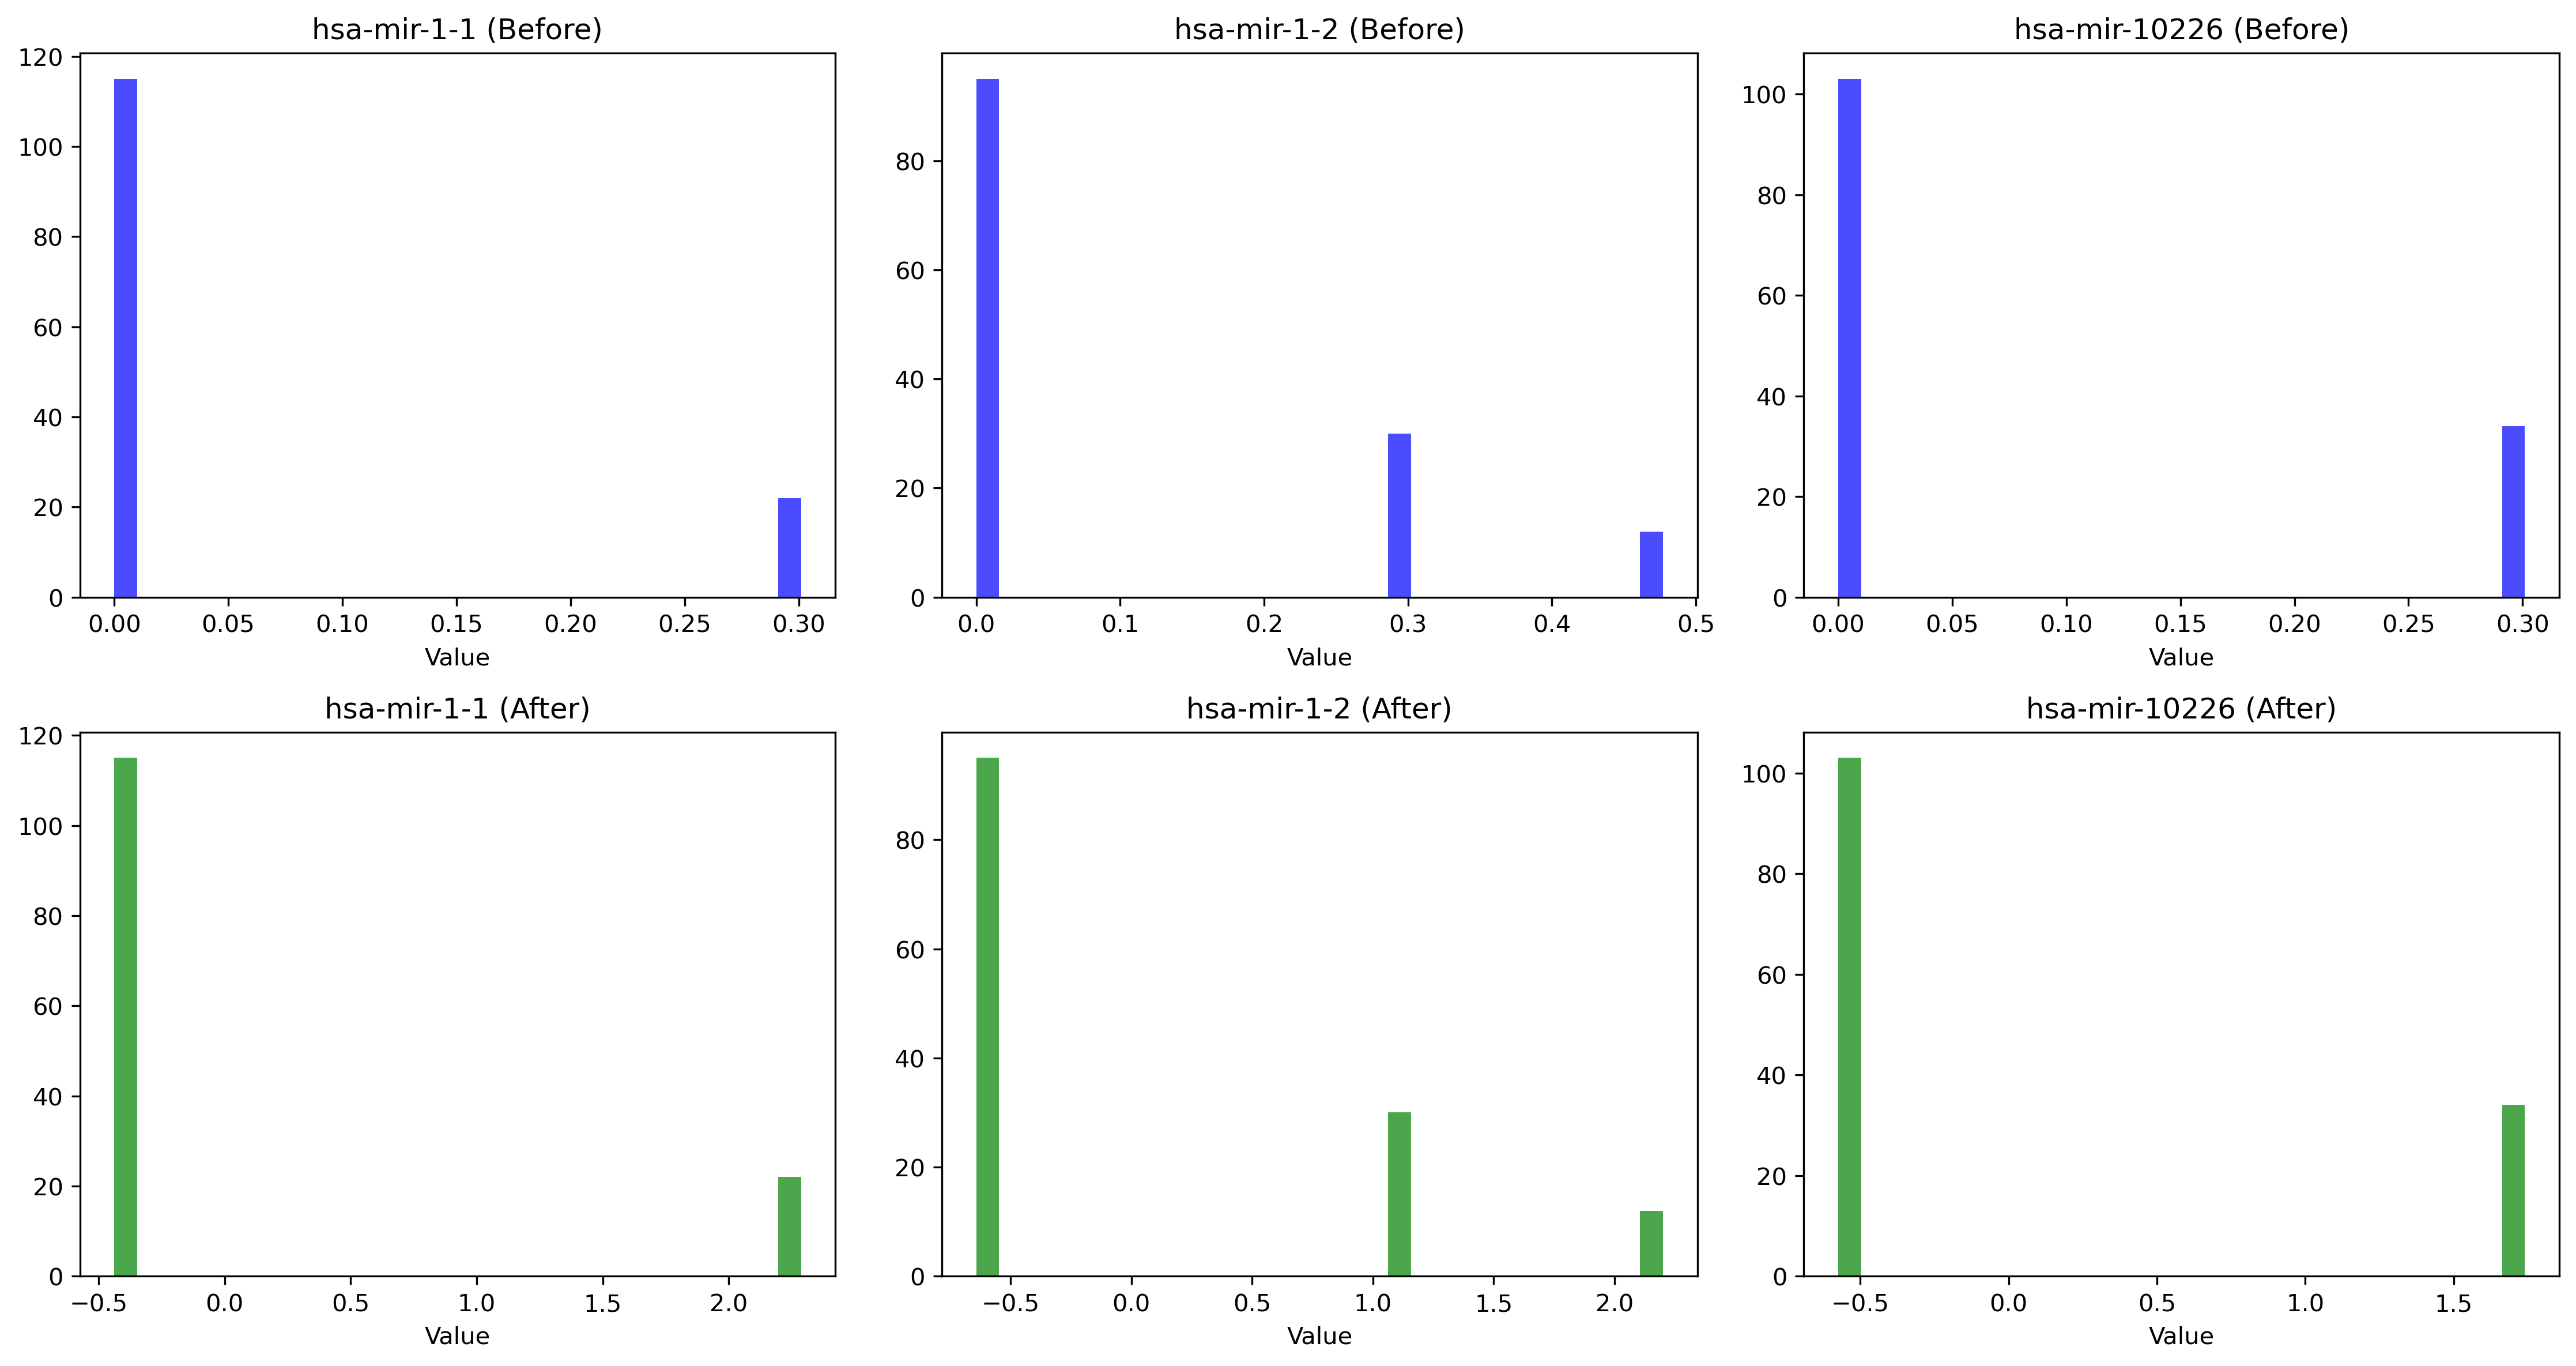


4.4 Statistical summary comparison:
Before preprocessing (first 3 features):
       hsa-mir-1-1  hsa-mir-1-2  hsa-mir-10226
count   137.000000   137.000000     137.000000
mean      0.048341     0.107711       0.074708
std       0.110928     0.168490       0.130508
min       0.000000     0.000000       0.000000
25%       0.000000     0.000000       0.000000
50%       0.000000     0.000000       0.000000
75%       0.000000     0.301030       0.000000
max       0.301030     0.477121       0.301030

After preprocessing (first 3 features):
        hsa-mir-1-1   hsa-mir-1-2  hsa-mir-10226
count  1.370000e+02  1.370000e+02   1.370000e+02
mean   1.296611e-17 -1.296611e-17   1.166950e-16
std    1.003670e+00  1.003670e+00   1.003670e+00
min   -4.373835e-01 -6.416157e-01  -5.745408e-01
25%   -4.373835e-01 -6.416157e-01  -5.745408e-01
50%   -4.373835e-01 -6.416157e-01  -5.745408e-01
75%   -4.373835e-01  1.151574e+00  -5.745408e-01
max    2.286323e+00  2.200523e+00   1.740521e+00

4.5 Data leakage

In [10]:
# Phase 4: Data Validation
print("Phase 4: Data Validation")
print("=" * 50)

# 4.1 Check for missing values
print("4.1 Checking for missing values...")
train_missing = np.isnan(X_train_scaled).sum()
test_missing = np.isnan(X_test_scaled).sum()

if train_missing == 0 and test_missing == 0:
    print("✓ No missing values found in processed data")
else:
    print(f"⚠️  Missing values found: Train={train_missing}, Test={test_missing}")

# 4.2 Check data types and value ranges
print("\n4.2 Checking data types and value ranges...")

# Check for infinite values
train_infinite = np.isinf(X_train_scaled).sum()
test_infinite = np.isinf(X_test_scaled).sum()

if train_infinite == 0 and test_infinite == 0:
    print("✓ No infinite values found")
else:
    print(f"⚠️  Infinite values found: Train={train_infinite}, Test={test_infinite}")

# Check value ranges
print("\nValue ranges (first 5 features):")
for i, feature in enumerate(final_features[:5]):
    train_min, train_max = X_train_scaled[:, i].min(), X_train_scaled[:, i].max()
    test_min, test_max = X_test_scaled[:, i].min(), X_test_scaled[:, i].max()
    print(f"  {feature}: Train[{train_min:.3f}, {train_max:.3f}], Test[{test_min:.3f}, {test_max:.3f}]")

# 4.3 Distribution comparison (before vs after)
print("\n4.3 Distribution analysis...")

# Create comparison plots for first 3 features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
original_train_data = train_df[final_features[:3]]

for i, feature in enumerate(final_features[:3]):
    # Before preprocessing
    axes[0, i].hist(original_train_data[feature], bins=30, alpha=0.7, color='blue')
    axes[0, i].set_title(f'{feature} (Before)')
    axes[0, i].set_xlabel('Value')
    
    # After preprocessing
    axes[1, i].hist(X_train_scaled[:, i], bins=30, alpha=0.7, color='green')
    axes[1, i].set_title(f'{feature} (After)')
    axes[1, i].set_xlabel('Value')

plt.tight_layout()
plt.show()

# 4.4 Statistical summary comparison
print("\n4.4 Statistical summary comparison:")
print("Before preprocessing (first 3 features):")
print(original_train_data.describe())

print("\nAfter preprocessing (first 3 features):")
processed_df = pd.DataFrame(X_train_scaled[:, :3], columns=final_features[:3])
print(processed_df.describe())

# 4.5 Data leakage verification
print("\n4.5 Data leakage verification...")
print("✓ Train-test split performed before feature engineering")
print("✓ Feature selection used only training data")
print("✓ Normalization fitted on training data only")
print("✓ Test data transformed using fitted transformers")
print("✓ No information from test set influenced preprocessing")

# 4.6 Quality metrics
print("\n4.6 Quality metrics:")
validation_metrics = {
    'train_shape': X_train_scaled.shape,
    'test_shape': X_test_scaled.shape,
    'feature_count': len(final_features),
    'train_missing': train_missing,
    'test_missing': test_missing,
    'train_infinite': train_infinite,
    'test_infinite': test_infinite
}

for metric, value in validation_metrics.items():
    print(f"  {metric}: {value}")

# Overall validation score
validation_score = 100
if train_missing > 0 or test_missing > 0:
    validation_score -= 20
if train_infinite > 0 or test_infinite > 0:
    validation_score -= 20

print(f"\nValidation Score: {validation_score}/100")
if validation_score >= 80:
    print("✓ Data validation passed")
else:
    print("⚠️  Data validation issues detected")

## Phase 5: Save Results

### What We're Saving

We'll save all the processed data and preprocessing information for use in subsequent notebooks:

1. **Processed Datasets**: Clean training and test sets
2. **Preprocessing Pipeline**: All transformers and parameters
3. **Feature Information**: Selected features and metadata
4. **Split Information**: Train-test split details
5. **Preprocessing Report**: Summary of all steps applied

### Why Save Everything?

1. **Reproducibility**: Ensure consistent preprocessing across runs
2. **Pipeline Continuity**: Next notebooks can use the same preprocessing
3. **Documentation**: Record all decisions and transformations
4. **Debugging**: Easy to trace issues back to preprocessing steps

### File Structure

- `processed_data.pkl`: Training and test datasets
- `preprocessing_pipeline.pkl`: All transformers and parameters
- `feature_info.pkl`: Feature selection and metadata
- `preprocessing_summary.json`: Human-readable summary

In [11]:
# Phase 5: Save Results
print("Phase 5: Save Results")
print("=" * 50)

# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Save processed datasets
processed_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'feature_cols': final_features,
    'label_col': label_col,
    'sample_id_col': sample_id_col,
    'train_indices': train_indices,
    'test_indices': test_indices
}

with open(output_dir / '03_processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)
print("✓ Processed datasets saved")

# 2. Save preprocessing pipeline
preprocessing_pipeline = {
    'imputer_info': imputer_info,
    'outlier_info': outlier_info,
    'feature_selection_info': feature_selection_info,
    'normalization_info': normalization_info,
    'split_info': split_info,
    'validation_metrics': validation_metrics,
    'validation_score': validation_score
}

with open(output_dir / '03_preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)
print("✓ Preprocessing pipeline saved")

# 3. Save feature information
feature_info = {
    'original_features': feature_cols,
    'final_features': final_features,
    'removed_correlated': feature_selection_info['removed_correlated_features'],
    'removed_low_variance': feature_selection_info['removed_low_variance_features']
}

with open(output_dir / '03_feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("✓ Feature information saved")

# 4. Create preprocessing summary
preprocessing_summary = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'original_shape': ingestion_data['data']['df'].shape,
        'cleaned_shape': df.shape,
        'train_shape': X_train_scaled.shape,
        'test_shape': X_test_scaled.shape
    },
    'preprocessing_steps': {
        'imputation': {
            'strategy': imputation_strategy,
            'features_imputed': len(features_with_missing) if features_with_missing is not None else 0
        },
        'outlier_treatment': {
            'method': outlier_method,
            'outliers_found': outlier_info['total_outliers'],
            'treatment_strategy': outlier_info.get('treatment_strategy', 'none')
        },
        'feature_selection': {
            'original_features': feature_selection_info['original_features'],
            'final_features': len(final_features),
            'correlation_removal': len(feature_selection_info['removed_correlated_features']),
            'variance_selection': len(feature_selection_info['removed_low_variance_features'])
        },
        'normalization': {
            'method': normalization_method,
            'features_normalized': len(final_features)
        }
    },
    'quality_metrics': {
        'validation_score': validation_score,
        'train_missing': train_missing,
        'test_missing': test_missing,
        'train_infinite': train_infinite,
        'test_infinite': test_infinite
    },
    'split_info': {
        'test_size': test_size,
        'stratify': stratify,
        'train_samples': X_train_scaled.shape[0],
        'test_samples': X_test_scaled.shape[0]
    },
    'data_leakage_prevention': {
        'split_before_feature_engineering': True,
        'feature_selection_on_training_only': True,
        'normalization_fitted_on_training_only': True,
        'test_data_unseen_during_preprocessing': True
    }
}

with open(output_dir / '03_preprocessing_summary.pkl', 'wb') as f:
    pickle.dump(preprocessing_summary, f)
print("✓ Preprocessing summary saved")

Phase 5: Save Results
✓ Processed datasets saved
✓ Preprocessing pipeline saved
✓ Feature information saved
✓ Preprocessing summary saved
